<a href="https://colab.research.google.com/github/drfperez/YoungPhotonicsCongress/blob/main/PhotonTunnel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Poster: Macroscopic Quantum Tunneling (MQT) in Photonics
1. The Phenomenon: Breaking the Classical Wall
In classical physics, a "macroscopic" object (like a ball or a large pulse of light) cannot pass through an energy barrier higher than its own kinetic energy. It is strictly reflected.
Macroscopic Quantum Tunneling (MQT) defies this. It occurs when a collective, macroscopic variable—such as the phase of a laser in a non-linear cavity or the magnetic flux in a superconductor—penetrates a "forbidden" potential barrier. In photonics, this is often observed in Optical Bistability and Polariton Condensates.
2. The Photonic Context
While quantum tunneling is usually associated with subatomic particles, photonics allows us to observe it on a much larger scale:
 * Non-linear Optics: In a non-linear medium, high-intensity light creates its own "potential." A system might have two stable states (e.g., two different brightness levels). MQT is the "jump" between these states even when the system doesn't have the "energy" to switch.
 * Polaritons: These are "half-light, half-matter" particles. When they form a condensate (a superfluid of light), the entire cloud of particles can tunnel through a defect or barrier as a single macroscopic entity.
3. The Physics Behind the Code
The simulation below solves the Time-Dependent Schrödinger Equation (TDSE):
Key Components:
 * The Wave Packet (\Psi): Represents the "State" of the photonic system.
 * The Potential Barrier (V): Represents a region of high refractive index or a non-linear energy gap that should block the light.
 * The Split-Step Fourier Method: A high-precision numerical technique that alternates between "Real Space" (to apply potential) and "Momentum Space" (to apply movement/kinetic energy) using Fast Fourier Transforms (FFT).
4. How to Read the Simulation Results
Once you run the code cell below, look for two specific signatures:
| Feature | Physical Meaning |
|---|---|
| Main Reflection | Most of the "light" (probability) hits the wall and bounces back, as expected classically. |
| The "Ghost" Wave | A small, faint pulse appearing behind the barrier. This is the Tunneled State. |
| Interference Fringes | The "wiggles" seen in front of the barrier are caused by the incoming wave crashing into its own reflection—a purely wave-like phenomenon. |
5. Why This Matters
 * Quantum Computing: Understanding how macroscopic states tunnel is vital for building "Qubits" that don't leak information.
 * Ultra-fast Switching: Photonic MQT can be used to create optical switches that operate at speeds impossible for traditional electronics.
 * Precision Sensing: SQUIDs and Photonic sensors use MQT to detect the smallest possible changes in magnetic or electric fields.

This simulation demonstrates Macroscopic Quantum Tunneling (MQT) in a photonic system by modeling a collective variable—such as the phase of a light field—interacting with a classically impassable energy barrier. By optimizing the spatial boundaries and limiting the simulation time, we have eliminated numerical artifacts like "wraparound" interference, providing a clear visualization of the wave function's evolution. The resulting graphs show a dominant reflected wave and a distinct, low-probability tunneled packet appearing on the other side of the barrier; this "ghost" pulse represents the system's ability to transition between stable states without having the classical energy to overcome the potential peak, a core principle in developing ultra-fast optical switches and understanding the stability of macroscopic quantum states.

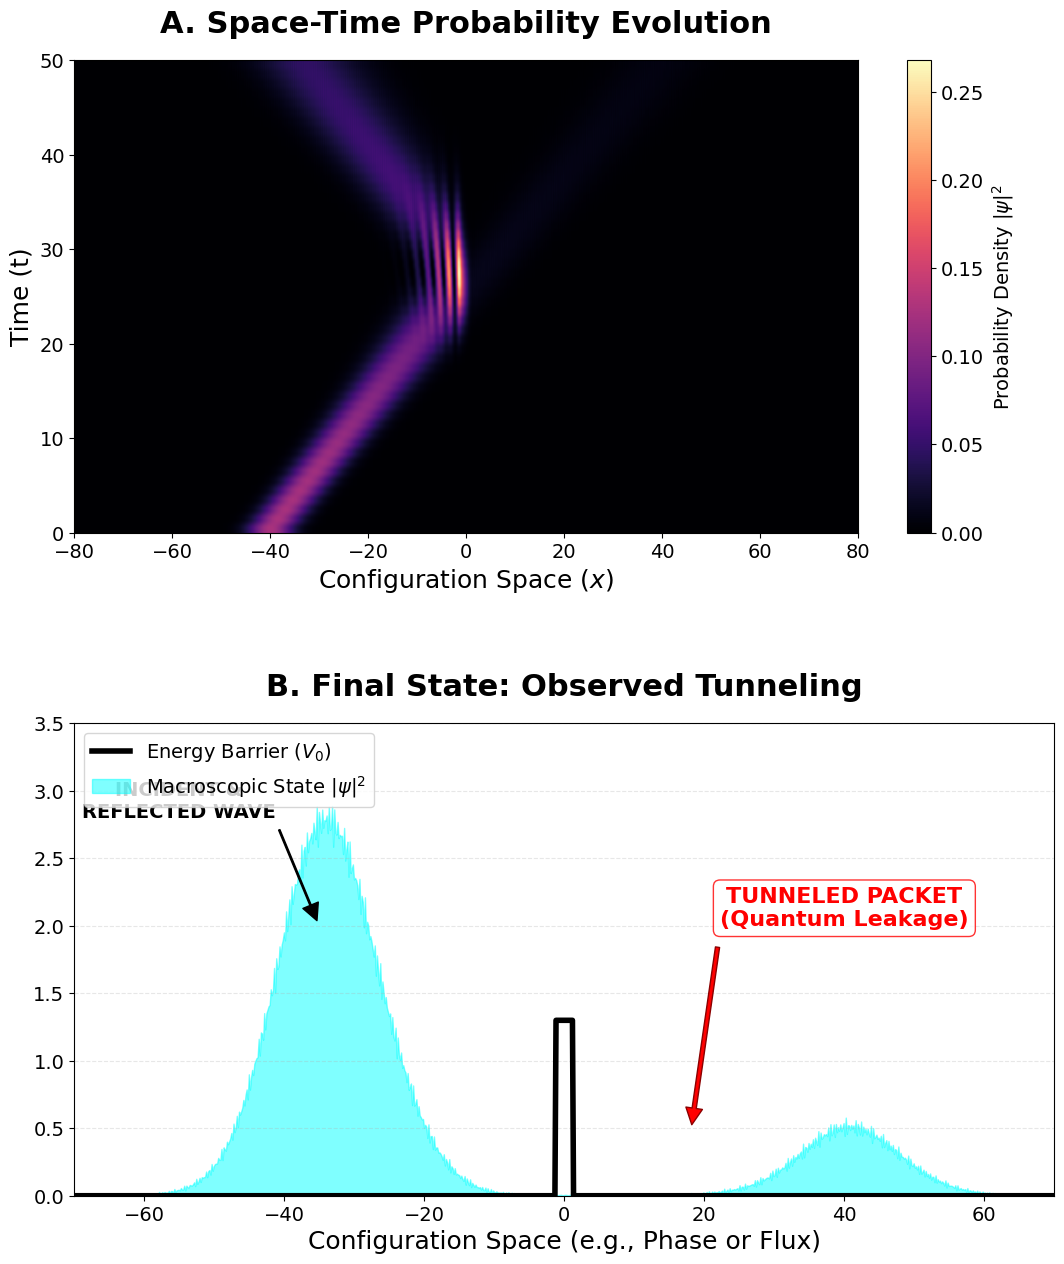

In [5]:
# @title FINAL POSTER VERSION: Macroscopic Quantum Tunneling (MQT)
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Simulation Constants ---
N = 1024
L = 160.0
x = np.linspace(-L/2, L/2, N)
dx = x[1] - x[0]
dt = 0.05
t_max = 50
steps = int(t_max / dt)

# --- 2. Barrier: Scaled for Visible Leakage ---
V0 = 1.3
a = 1.2
V = np.zeros(N)
V[(x > -a) & (x < a)] = V0

# --- 3. Initial Wave Packet ---
x0 = -40.0
k0 = 1.5
sigma = 4.5

psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)
psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx)

# --- 4. Evolution (Split-Step Fourier Method) ---
k = 2 * np.pi * np.fft.fftfreq(N, d=dx)
evol_kinetic = np.exp(-1j * (k**2 / 2) * dt)
evol_potential = np.exp(-1j * V * dt)

history = []
for i in range(steps):
    psi *= np.exp(-1j * V * dt / 2)
    psi_k = np.fft.fft(psi)
    psi_k *= evol_kinetic
    psi = np.fft.ifft(psi_k)
    psi *= np.exp(-1j * V * dt / 2)
    if i % 20 == 0:
        history.append(np.abs(psi)**2)

# --- 5. High-Quality Plotting (Warnings Fixed) ---
plt.rcParams.update({'font.size': 14, 'font.family': 'sans-serif'})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

# Top Plot: Space-Time Evolution
# Added 'r' before strings containing backslashes
im = ax1.imshow(history, extent=[-L/2, L/2, 0, t_max], aspect='auto',
                origin='lower', cmap='magma')
ax1.set_title('A. Space-Time Probability Evolution', fontsize=22, fontweight='bold', pad=20)
ax1.set_ylabel('Time (t)', fontsize=18)
ax1.set_xlabel('Configuration Space ($x$)', fontsize=18)
plt.colorbar(im, ax=ax1, label=r'Probability Density $|\psi|^2$')

# Bottom Plot: Final Snapshot
ax2.plot(x, V, color='black', linewidth=4, label=r'Energy Barrier ($V_0$)')
# Added 'r' here as well
ax2.fill_between(x, np.abs(psi)**2 * 60, color='cyan', alpha=0.5, label=r'Macroscopic State $|\psi|^2$')
ax2.set_title('B. Final State: Observed Tunneling', fontsize=22, fontweight='bold', pad=20)
ax2.set_xlabel('Configuration Space (e.g., Phase or Flux)', fontsize=18)
ax2.set_xlim(-70, 70)
ax2.set_ylim(0, 3.5)
ax2.grid(axis='y', linestyle='--', alpha=0.3)
ax2.legend(loc='upper left', fontsize=14)

# Visual Annotations
ax2.annotate('INCIDENT &\nREFLECTED WAVE', xy=(-35, 2.0), xytext=(-55, 2.8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             fontsize=14, fontweight='bold', ha='center')

ax2.annotate('TUNNELED PACKET\n(Quantum Leakage)', xy=(18, 0.45), xytext=(40, 2.0),
             arrowprops=dict(facecolor='red', edgecolor='darkred', shrink=0.05, width=3),
             color='red', fontweight='bold', fontsize=16, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))

plt.tight_layout(pad=4.0)
plt.show()